In [1]:
import pandas as pd
import os
import re
from dataclasses import dataclass
import json
%matplotlib inline

In [2]:
jobname_regex = re.compile(r"(?<=: \[)(?P<project>[a-z-]+), (?P<noise_type>[a-z-]+)")

In [3]:
test_string = "Test Projects: [shiki, baseline]"

res = jobname_regex.search(test_string)

# Read in all Results

In [4]:
directory = "./results"
jobs_dir = os.listdir(directory)
f"{len(jobs_dir)} jobs found"

'152 jobs found'

In [5]:
@dataclass
class TestResult:
    project: str
    noise_type: str
    dir: str
    test_results: dict[str, dict[str, int]]
    env_vars: dict[str, str]
    job_number: int

    test_df: pd.DataFrame = None

    def __post_init__(self):
        # Compute the test_df
        # Columns: test_name, PASSED, Failed, Skipped, TOTAL RUNS
        test_names = self.test_results.keys()
        passed = [test.get("PASSED", 0) for test in self.test_results.values()]
        failed = [test.get("FAILED", 0) for test in self.test_results.values()]
        skipped = [test.get("SKIPPED", 0) for test in self.test_results.values()]

        self.test_df = pd.DataFrame({
            "test_name": test_names,
            "PASSED": passed,
            "FAILED": failed,
            "SKIPPED": skipped
        })
        self.test_df["TOTAL RUNS"] = self.test_df["PASSED"] + self.test_df["FAILED"]


In [6]:
results: list[TestResult] = []
for job in jobs_dir:
    with open(os.path.join(directory, job, "jobname.txt")) as f:
        job_str = f.read()
    job_re = jobname_regex.search(job_str)

    with open(os.path.join(directory, job, "aggregated_test_results.json")) as f:
        test_results = json.load(f)

    with open(os.path.join(directory, job, "environment_variables.json")) as f:
        env_vars = json.load(f)

    results.append(TestResult(
        project=job_re.group("project"),
        noise_type=job_re.group("noise_type"),
        dir=os.path.join(directory, job),
        test_results=test_results,
        env_vars=env_vars,
        job_number=int(job)
    ))

In [7]:
f"parsed {len(results)} results"

'parsed 152 results'

In [8]:
x =results[1].test_df.sort_values("FAILED")

In [9]:
results[1].noise_type


'disk'

In [10]:
results[14].test_df.iloc[1]

test_name     Firefox/full.spec.ts/compose an epic
PASSED                                          81
FAILED                                          19
SKIPPED                                          0
TOTAL RUNS                                     100
Name: 1, dtype: object

# Remove job with the same project and noise type

In [11]:
results_dict : dict[tuple[str, str], TestResult] = {}
for result in results:
    key = (result.project, result.noise_type)
    if key in results_dict:
        if results_dict[key].job_number < result.job_number:
            results_dict[key] = result
    else:
        results_dict[key] = result

In [12]:
f"Filtered {len(results) - len(results_dict)} results"

'Filtered 36 results'

In [13]:
results = list(results_dict.values())

# Single Analysis DF of all results

Columns: project
Rows: noise_type
Element: flakyness in %

## Formula

$$
flakyness = \begin{cases}
0, all\ tests\ failed\\
\frac{Failed\ Tests}{Total\ Test\ Runs}, else
\end{cases}
$$

In [14]:
# define a function to compute the flakyness
def compute_flakyness(df: pd.DataFrame) -> float:
    lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"]

    df["flakyness"] = df.apply(lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"], axis=1)
    return df["flakyness"].mean()

flakyness = [compute_flakyness(result.test_df) for result in results]

In [15]:
noise_types: set[str] = set()
projects: set[str] = set()

for (pj, nt) in results_dict:
    noise_types.add(nt)
    projects.add(pj)

print(f"Got noise_types: {noise_types} and projects {projects}")

Got noise_types: {'disk', 'memory', 'cpu', 'packet', 'baseline', 'bandwidth', 'network', 'interrupt'} and projects {'shiki', 'ionic-framework', 'playwright', 'lenster', 'remix', 'material-ui', 'rocket-chat', 'floating-ui', 'gatsby', 'logseq', 'quill', 'storybook', 'insomnia', 'dev-roadmap', 'docs'}


In [16]:
overview_dict: dict[str, list[float]] = {}

for noise in noise_types:
    for project in projects:
        curr_val: list[float] = overview_dict.get(project, [])

        val = float("nan")

        if (project, noise) in results_dict:
            val = compute_flakyness(results_dict[(project, noise)].test_df)
        else:
            f"Missing data for project {project} and noise type {noise}"
        curr_val.append(val)
        overview_dict[project] = curr_val

overview = pd.DataFrame(overview_dict, index=list(noise_types))

In [17]:
overview

,shiki,ionic-framework,playwright,lenster,remix,material-ui,rocket-chat,floating-ui,gatsby,logseq,quill,storybook,insomnia,dev-roadmap,docs
disk,0.000000,0.000358,0.000032,0.000053,0.000322,0.000000,0.027694,0.0,0.0,0.012038,0.070000,0.017771,0.030093,0.061795,0.0
memory,0.000000,0.000375,0.000051,0.000105,0.000123,0.000000,0.017903,0.0,0.0,0.205375,0.010000,NaN,0.008239,0.078205,0.0
cpu,0.000000,0.000247,0.000186,0.000106,0.000521,0.000000,0.016944,0.0,0.0,0.140308,0.080000,0.010000,0.013593,0.060256,0.0
packet,0.231667,0.000520,0.000413,0.019015,0.000475,0.358122,0.023977,0.0,0.0,0.131839,0.513333,0.009048,0.010621,0.085897,0.0
baseline,0.000000,0.002079,0.000075,0.000264,0.000429,0.000000,0.035184,0.0,0.0,0.228221,0.013333,0.009429,0.008220,0.065385,0.0
bandwidth,0.000000,NaN,0.000082,0.000000,0.000521,0.000417,0.203623,0.0,0.0,0.218522,0.003333,0.009619,0.006944,0.085897,0.0
network,0.000000,NaN,0.000016,0.000785,0.000107,0.000417,0.017097,0.0,0.0,0.227870,0.000000,0.008476,0.000278,0.078205,0.0
interrupt,0.000000,0.000721,0.000064,0.000052,0.000199,0.001250,0.015985,0.0,0.0,0.186607,0.000000,NaN,0.006944,0.055641,0.0


# Number of flaky tests in total, without any noise, with noises

## How many flaky tests in total?

In [18]:
flaky_tests = []

for result in results:
    for index, row in result.test_df.iterrows():
        if row['PASSED'] != 0 and row['FAILED'] != 0:
            flaky_tests.append(row['test_name'])
        
flaky_tests_in_total = len(list(set(flaky_tests)))
print(f"Flaky tests in total: {flaky_tests_in_total}")

Flaky tests in total: 489


## How many flaky tests are there without any noise?

In [19]:
import matplotlib.pyplot as plt

flaky_tests_without_noises = 0
tests_in_total = 0

for result in results:
    if result.noise_type == 'baseline':
        for index, row in result.test_df.iterrows():
            tests_in_total += 1
            if row['PASSED'] != 0 and row['FAILED'] != 0:
                flaky_tests_without_noises += 1

print(f"Tests in total: {tests_in_total}")
print(f"Flaky tests without noise: {flaky_tests_without_noises}")

Tests in total: 12100
Flaky tests without noise: 283


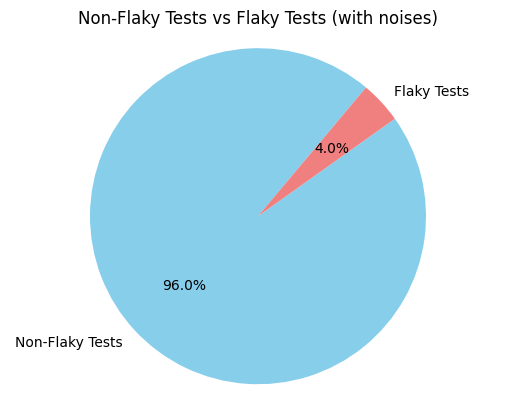

In [20]:
# Compute the number of non-flaky tests
non_flaky_tests = tests_in_total - flaky_tests_in_total

# Create data for the pie chart
labels = ['Non-Flaky Tests', 'Flaky Tests']
sizes = [non_flaky_tests, flaky_tests_in_total]
colors = ['skyblue', 'lightcoral']

# Create the pie chart with a rotated start angle of 135 degrees
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=50)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.title('Non-Flaky Tests vs Flaky Tests (with noises)')

# Save the pie chart as an image file
plt.savefig('Noises_pie_chart.png', dpi=300)

# Display the pie chart
plt.show()



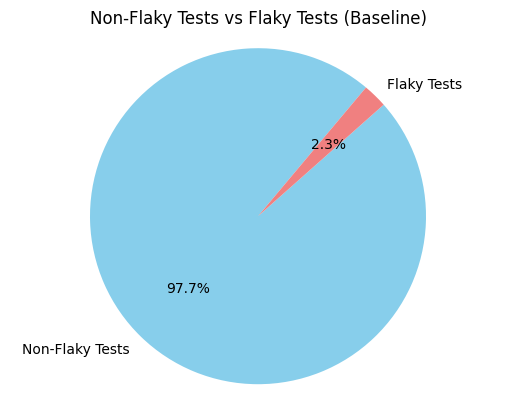

In [21]:
# Compute the number of non-flaky tests
non_flaky_tests = tests_in_total - flaky_tests_without_noises

# Create data for the pie chart
labels = ['Non-Flaky Tests', 'Flaky Tests']
sizes = [non_flaky_tests, flaky_tests_without_noises]
colors = ['skyblue', 'lightcoral']

# Create the pie chart with a rotated start angle of 135 degrees
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=50)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.title('Non-Flaky Tests vs Flaky Tests (Baseline)')

# Save the pie chart as an image file
plt.savefig('Baseline_pie_chart.png', dpi=300)

# Display the pie chart
plt.show()

# How many tests became flaky with noise?

In [22]:
print(f"Tests which became flaky only with noise: {flaky_tests_in_total - flaky_tests_without_noises}")

Tests which became flaky only with noise: 206


## Result's overview

In [23]:
percentage_flaky = (flaky_tests_without_noises / tests_in_total) * 100

# Create a table using pandas DataFrame
table = pd.DataFrame({
    'Total Tests': [tests_in_total],
    'Flaky Tests without noise': [flaky_tests_without_noises],
    '% of Flaky Tests': [percentage_flaky]
})

table

,Total Tests,Flaky Tests without noise,% of Flaky Tests
0,12100,283,2.338843


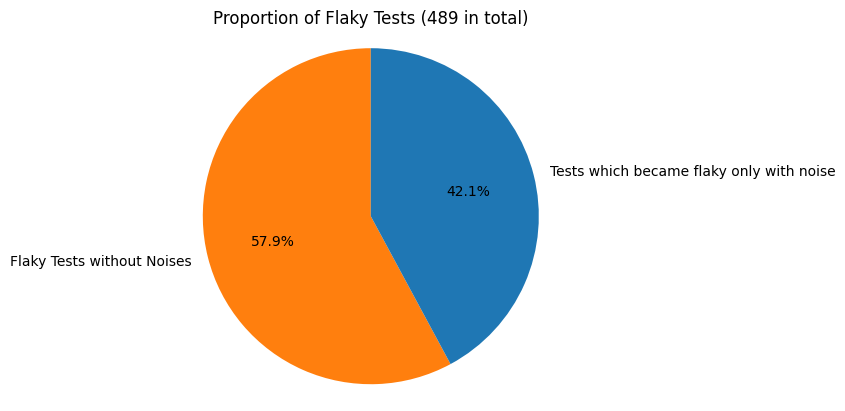

In [24]:
flaky_tests_only_with_noise = flaky_tests_in_total - flaky_tests_without_noises

labels = ['Flaky Tests without Noises', 'Tests which became flaky only with noise']
sizes = [flaky_tests_without_noises, flaky_tests_only_with_noise]
colors = ['#ff7f0e', '#1f77b4']

plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title(f'Proportion of Flaky Tests ({flaky_tests_in_total} in total)')

plt.show()

## Find tests which are much more flaky for a specific noise

In [38]:
import pandas as pd

test_flakiness = {}

for result in results:
    for index, row in result.test_df.iterrows():
        test_name = row['test_name']
        if row['TOTAL RUNS'] == 0:
            continue
        flakiness = (0 if row['FAILED'] / row['TOTAL RUNS'] == 1 else row['FAILED'] / row['TOTAL RUNS'])
        noise_type = result.noise_type
        project_name = result.project

        key = (test_name, noise_type)

        if key not in test_flakiness:
            test_flakiness[key] = {'Flakiness': flakiness, 'Project Name': project_name}

# Step 1: Group elements by test_name
grouped_by_test = {}

for (test_name, noise_type), data in test_flakiness.items():
    if test_name not in grouped_by_test:
        grouped_by_test[test_name] = []
    grouped_by_test[test_name].append((noise_type, data['Flakiness'], data['Project Name']))

# Step 2 and 3: Find noise type with the biggest flakiness and subtract from baseline
analysis_results = []

for test_name, test_data in grouped_by_test.items():
    max_flakiness = 0
    max_noise_type = None
    baseline_flakiness = None
    project_name = None

    for noise_type, flakiness, project_name in test_data:
        if flakiness > max_flakiness:
            max_flakiness = flakiness
            max_noise_type = noise_type

        if noise_type == 'baseline':
            baseline_flakiness = flakiness

    if baseline_flakiness is not None and max_noise_type is not None and baseline_flakiness != 0:
        diff_flakiness = max_flakiness - baseline_flakiness
        analysis_results.append((test_name, max_noise_type, diff_flakiness, project_name, baseline_flakiness))

# Step 4: Sort the analysis results by flakiness difference
sorted_results = sorted(analysis_results, key=lambda x: x[2])

# Create a DataFrame from the sorted results
df = pd.DataFrame(sorted_results, columns=['Test Name', 'Noise Type', 'Diff Flakiness', 'Project Name', "baseline_flakiness"])

# Filter the DataFrame by project_name
project_name_filter = df['Project Name'] == 'lenster'
filtered_df = df[project_name_filter]

# Get a single row (row 250) as a DataFrame
single_row_df = df.iloc[[250]]

# Display the single row as a table
print(filtered_df)



                                             Test Name Noise Type  \
221  chromium/apps/web/profile/sidebar.spec.ts/Prof...     packet   
246  chromium/apps/prerender/publication.spec.ts/sh...     packet   
248  chromium/apps/prerender/publication.spec.ts/sh...     packet   
250  chromium/apps/prerender/publication.spec.ts/sh...     packet   

     Diff Flakiness Project Name  baseline_flakiness  
221        0.039899      lenster            0.010101  
246        0.353131      lenster            0.020202  
248        0.379509      lenster            0.010101  
250        0.402399      lenster            0.010101  
